# Distributed modeling with static schedule

In [2]:
using Distributed, PyPlot

In [3]:
addprocs(2)

2-element Array{Int64,1}:
 2
 3

In [5]:
@everywhere using DistributedArrays, DistributedJets, Jets, WaveFD, JetPackWaveFD, Random

In [6]:
v = read!("../02_marmousi_model_setup/marmousi_vp_20m_176x851.bin", Array{Float32}(undef, 176,851));
dz,dx = 20.0,20.0
nz,nx = size(v)
@show dz,dx
@show nz,nx;

(dz, dx) = (20.0, 20.0)
(nz, nx) = (176, 851)


In [7]:
sx = range(0,length=4,stop=(851-1)*20)
nshots = length(sx)
@show nshots;

nshots = 4


In [8]:
@everywhere scratchdir = "/scratch"

In [9]:
@everywhere function makeF(i,sx)
    nz,nx,dz,dx = 176,851,20.0,20.0    
    JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS,2),
        ntrec = 1101,
        dtrec = 0.002,
        dtmod = 0.001,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=5.0),
        sx = sx[i],
        sz = dz,
        rx = dx*[0:1:nx-1;],
        rz = 2*dz*ones(length(0:1:nx-1)),
        srcfieldfile = "$scratchdir/field-$i.$(randstring()).bin",
        reportinterval=1000)
end

In [10]:
F = @blockop DArray(I->[makeF(i,sx) for i in I[1], j in I[2]], (nshots,1))

"Jet nonlinear operator, (176, 851) → (3747804,)"

In [11]:
d = F*v;

[ Info: nonlinear forward on cbox-wask-D16s-v3, srcfieldfile=/scratch/field-1.XV38miAX.bin
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step     1 of  2201 ;    0.00 MCells/s (IO= 0.00%, EX= 0.00%) -- rms d,p; 0.0000e+00 0.0000e+00
[ Info: nonlinear forward on cbox-wask-D16s-v3, srcfieldfile=/scratch/field-3.NJ7HwRHI.bin
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step     1 of  2201 ;    0.00 MCells/s (IO= 0.00%, EX= 0.00%) -- rms d,p; 0.0000e+00 0.0000e+00
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  1000 of  2201 ;   12.41 MCells/s (IO= 5.96%, EX= 4.43%) -- rms d,p; 1.5478e+00 7.6726e-01
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  1000 of  2201 ;   12.34 MCells/s (IO= 6.90%, EX= 4.83%) -- rms d,p; 2.0917e+00 1.1267e+00
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  2000 of  2201 ;   12.44 MCells/s (IO= 6.08%, EX= 4.27%) -- rms d,p; 1.6396e+00 7.7765e-01
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, no

3747804-element DBArray{Float32,Jets.BlockArray{Float32,Array{Float32,2}},Array{Jets.BlockArray{Float32,Array{Float32,2}},1}}:
  0.0
 -2.2683205f-6
 -3.4405075f-5
 -0.00015984788
 -0.00047043653
 -0.0010728828
 -0.0020725592
 -0.0035586846
 -0.005594665
 -0.008216138
 -0.011437477
 -0.015265568
 -0.019718068
  ⋮
  0.19003473
  0.16901281
  0.14753777
  0.12565523
  0.103411525
  0.08085345
  0.058028005
  0.034982122
  0.011762455
 -0.011584714
 -0.035013497
 -0.05847832

## Look at shot 2

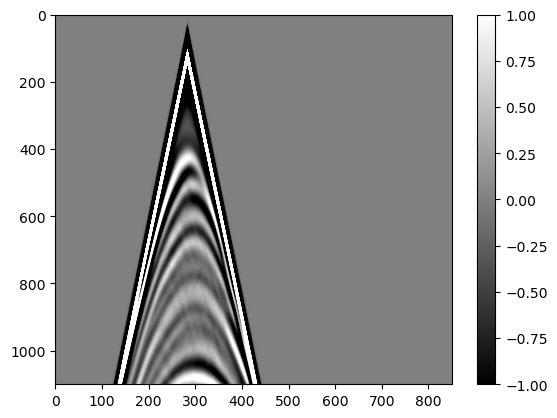

In [12]:
ishot = 2
trcs = getblock(d,ishot)
imshow(trcs,aspect="auto",cmap="gray");clim(-1,1);colorbar();

## Remove source field files on local disk

In [13]:
close(F)

## Remove workers

In [14]:
rmprocs(workers())

Task (done) @0x00007f8143167820